In [ ]:
using PauliPropagation
using Base.Threads: @threads, Atomic, atomic_add!
using Plots
using Bits
using Statistics
using DataStructures
using Serialization
using OrderedCollections
using JSON
using Random
cd(@__DIR__)
if isfile("paulipropagation.jl/helpers.jl")
    include("paulipropagation.jl/helpers.jl")
elseif isfile("helpers.jl")
    include("helpers.jl")
else
    error("Cannot find helpers.jl")
end


produceLabels2 (generic function with 1 method)

Quick start guide to dataset production. For more detailed and general production, see file __

In [7]:
"""Firstly, we inplement step 1: the production of a training set of Paulis. These are deemed relevant since they were produced from interesting generators"""

numQbits = 20 # Even number
numLayers = 3
topology = bricklayertopology(numQbits; periodic=true) # currently this is the 1d circle
circuit = tfitrottercircuit(numQbits, numLayers; topology=topology) # applies nl layers of the tfi trotterised

dt = 0.1
parameters = ones(countparameters(circuit)) * dt 

generators = PauliSum(numQbits) # from section 2 step 1 in report
for d in 1:fld(numQbits, 2)
    add!(generators,PauliString(numQbits, [:Z, :Z], [1, 1 + d]))
end

gen_bool = true
max_weight = Inf
min_abs_coeff = 0.00123418
total = 0

training_psum = PauliSum(numQbits)

training_psum = propagate(circuit, generators, parameters;
                    max_weight=max_weight,
                    min_abs_coeff=min_abs_coeff)

println("total collected = ", length(training_psum))
print(training_psum)



total collected = 231
PauliSum(nqubits: 20, 231 Pauli terms:
 0.080905 * YIIIIYIIIIIIIIIIIIII
 -0.011289 * IYZIIIIIIIIIIIIIIIII
 0.26939 * ZIYIIIIIIIIIIIIIIIII
 0.0014976 * XIIIIIXZIIIIIIIIIIIZ
 0.0014834 * XZIIIIXZIIIIIIIIIIII
 0.014785 * YIIIIIIIIIXZIIIIIIII
 0.01486 * YZXIIIIIIIIIIIIIIIII
 0.0014976 * XIIIZXIIIIIIIIIIIIIZ
 0.26939 * ZIIIIIIIIYIIIIIIIIII
 0.080905 * YIIIIIYIIIIIIIIIIIII
 -0.001491 * YIIIZYZIIIIIIIIIIIII
 0.054896 * ZIZXIIIIIIIIIIIIIIII
 0.01486 * YIIXZIIIIIIIIIIIIIII
 -0.011186 * YZIIIIZIIIIIIIIIIIIZ
 0.002844 * XIIIIZIIIIIIIIIIIIIY
 0.0014976 * XIIIIIIIIZXIIIIIIIIZ
 -0.001491 * YIIZYZIIIIIIIIIIIIII
 0.054896 * ZIIIIIZXIIIIIIIIIIII
 0.014719 * XZIIIYIIIIIIIIIIIIII
 0.014719 * XZIIYIIIIIIIIIIIIIII
  ⋮)

Now step 2 is done, the accurate production of labels for each of the P in S, the set produced above

In [ ]:
L2 = Integer(2)
L2_cp_thrshld = 1e-15 #ideally, this should be 0

trainingDataDict = produceLabels(numQbits, training_psum, L2, L2_cp_thrshld, topology, dt)

sortedTrainingDataSet = OrderedDict(sort(collect(trainingDataDict), by = x ->  x.second))

filename = string("datasets/len=",length(sortedTrainingDataSet),"_qbits=", numQbits,"_{Gen=",gen_bool,"_L1=", numLayers,"_cp=", min_abs_coeff,"_w=", max_weight,"}_{L2=", L2, "_cp=",L2_cp_thrshld,"}")

open(string(filename,".json"), "w") do f
    JSON.print(f, sortedTrainingDataSet)
end

println(length(sortedTrainingDataSet))

processed 200/231231


We can also load old datasets to investigate them

first entry: 481052196903 => Any[1.0858606168016216e-5, 2.002678623047758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


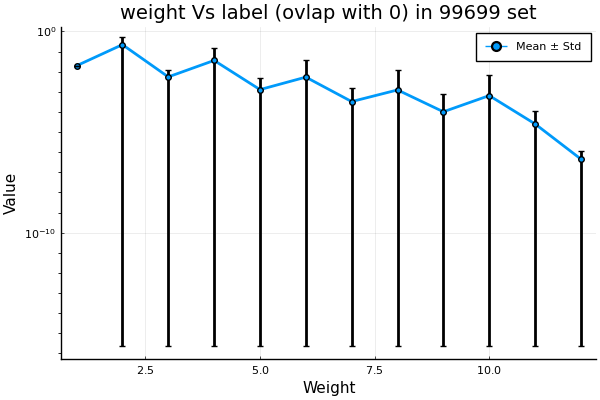

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping p

In [ ]:
"""Load a training data set like so:"""
name = "../datasets/len=100004_qbits=20_{Gen=true_L1=32_cp=0.00123418_w=Inf}_{L2=2_cp=1.0e-15}.json"
dict = JSON.parsefile(name)

key   = first(keys(dict))  # just the first key
value = dict[key]  # just the first value

println("first entry: ", key, " => ", value)

pyplot()

using Plots, Statistics

# Group values by weight
weight_to_values = Dict{Int, Vector{Float64}}()

for (key, val) in dict
    weight = countweight(parse(Int, key))
    if !haskey(weight_to_values, weight)
        weight_to_values[weight] = Float64[]
    end
    push!(weight_to_values[weight], abs(val[1]))
end

# Calculate means and stds
weights = sort(collect(keys(weight_to_values)))
means = [mean(weight_to_values[w]) for w in weights]
stds = [std(weight_to_values[w]) for w in weights]

# Plot with error bars
plot(weights, means,
     yerror=stds,
     xlabel="Weight",
     ylabel="Value", 
     yscale=:log10,
     label="Mean ± Std",
     linewidth=2,
     marker=:circle)
title!("weight Vs label (ovlap with 0) in training set")

In [ ]:
""" To investigate the cp distribution before sum logging, use this code"""

# psum = propagate(circuit, generators[1], parameters; max_weight=max_weight, min_abs_coeff=min_abs_coeff)

# trainingDataDict, cps = produceLabels(numQbits, psum, Integer(4), 0, topology, dt)

# using Plots
# pyplot()

# eps = 1e-12

# for (i, k) in enumerate(cps)
#     # filter out nonpositive/NaN/Inf
#     clean = [max(x, eps) for x in k if isfinite(x)]
    
#     if isempty(clean)
#         println("Bucket $i has no positive finite values, skipping")
#         continue
#     end
    
#     xmin, xmax = minimum(clean), maximum(clean)
    
#     # optional: expand limits slightly to avoid matplotlib rounding issues
#     xlims = (xmin*0.9, xmax*1.1)
#     nbins=100
#     edges = 10 .^ range(floor(log10(minimum(k))), ceil(log10(maximum(k))), length=nbins+1)
#     display(histogram(clean; xscale=:log10, xlims=xlims, xlabel="value", ylabel="count",
#               bins=edges, title="Bucket $i"))
# end


" To investigate the cp distribution before sum logging, use this code"

In [ ]:
"""code to investigate proper mixing of paulis"""
# psums=[]
# push!(psums,psum)
# vals=[]
# for psum in psums
#     println(length(psum))
#     arr=[]
#     for i in range(start = 1, stop = 63, step=2)
#         push!(arr,count(==(0),[term.x for term in [bits(v)[i:i+1] for v in keys(psum.terms)]])/length(psum))
#     end
#     push!(vals,arr)
# end
# print("Training set 1 is one IIIZIII... , whereas 2 is their weird mixed string")
# # plot(a1, title= "proportion of Identities at qbit x in training pauli set 1")
# pyplot()
# plot()
# for (k, i) in enumerate(vals)
#     label = string(min_abs_coeff, ". len=", length(psums[k]))
#     plot!(i, label=label, title=string("Proportion of Identies at position x in training set. layers=", numLayers),legend = :bottomright)
# end

# hline!([0,0.25], label="fully mixed" )

LoadError: UndefVarError: `psum` not defined in `Main`
Suggestion: check for spelling errors or missing imports.